# 0.0 Imports

In [66]:
import inflection
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
from sklearn         import preprocessing  as pp
from sklearn import manifold      as mn
from sklearn import ensemble      as en
from sklearn import decomposition as dd
from pandas_profiling import ProfileReport
from IPython.display import HTML

## 0.1 Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
# Carregando dados
df_raw = pd.read_csv('../data/Ecommerce.csv')

In [6]:
# Dropando coluna extra
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

In [7]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Data Description

In [8]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [9]:
# Mudar para snake case
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snake_case = lambda x: inflection.underscore(x)

new_cols = list( map(snake_case, old_cols))
df1.columns = new_cols

## 1.2 Data Dimensions

In [10]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data Types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fill NA

In [13]:
# Dropando valores NA nas colunas 'description' e 'customer_id'
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


## 1.6 Change dtypes

In [14]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

df1['customer_id'] = df1['customer_id'].astype(np.int64)

### 1.6.1 Final Check

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Estatistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.2 Categorical Attributes

#### 1.7.2.1 Invoice No

In [18]:
# Temos invoice com letras e numeros

# Identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 8905
Total number of negative quantity: 8905


#### 1.7.2.2 Stock Code

In [19]:
# Checagem do stock code 
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

#### 1.7.2.3 Country

In [20]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [21]:
df_countries = df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values( 'customer_id', ascending=False).head()
df_countries

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# 2.0 Variable Filtering

In [22]:
df2 = df1.copy()

In [23]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [24]:
df3 = df2.copy()

## Modelo RFM

RFM é a junção de três siglas: Recência, Frequência e Monetaridade. Essa técnica lhe permitirá entender melhor seu cliente ao verificar quando foi sua última compra, quantas vezes ele já comprou e quanto já gastou com sua empresa. Nesse sentido, tem como principal objetivo fidelizar e recompensar quem já ama a marca e reativar quem está prestes a deixar de usá-la, munindo-se de uma técnica chamada Targeting Marketing. Nessa técnica, campanhas e ações são direcionadas à pessoas que fazem parte de um mesmo segmento, visando assim uma taxa de conversão maior e, consequentemente, maior receita.

- Recency( Recência ): Tempo desde a última compra

- Frequency( Frequência ): Frequência de compra

- Monetary( Valor gasto ): Valor total de compra

In [25]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

## 3.1 Gross Revenue

In [26]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/var/folders/wt/4bhdq9gj4vnbrm086fldm7z80000gn/T/ipykernel_3163/206990356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

## 3.2 Recency

In [27]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

## 3.3 Quantity of purchased

In [28]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
dtype: int64

## 3.4 Quantity total of items purchased

In [29]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
dtype: int64

## 3.5 Quantity of products purchased

In [30]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
qtde_products    27
dtype: int64

## 3.5 Average Ticket Value

In [31]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
qtde_products    27
avg_ticket       27
dtype: int64

## 3.1.6 Average Recency Days

In [32]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
dtype: int64

## 3.7 Frequency Purchase

In [33]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
frequency             27
dtype: int64

## 3.8 Number of Returns

In [34]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
frequency             27
qtde_returns           0
dtype: int64

## 3.9 Basket Size - Quantidade de Items por Cesta ( Quantity )

In [35]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1386
frequency             27
qtde_returns           0
avg_basket_size       27
dtype: int64

## 3.10 Unique Basket Size - Quantidade de produtos distintos por compra

In [36]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               27
recency_days                27
qtde_invoices               27
qtde_items                  27
qtde_products               27
avg_ticket                  27
avg_recency_days          1386
frequency                   27
qtde_returns                 0
avg_basket_size             27
avg_unique_basket_size      27
dtype: int64

# 4.0 EDA

In [37]:
df4 = df3.copy()

In [38]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [39]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')

Metricas para olharmos
1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range ( Dispersão )
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação ( CV )
    - Distribuição

### 4.1.1 Gross Revenue

In [40]:
df4.sort_values( 'gross_revenue', ascending=False ).head() 

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
908,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.203390,288.0,2733.944444,9.708333
449,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,-14.680000,0.163043,0.0,1068.733333,2.500000
401,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,-12.821429,0.127778,952.0,1521.586957,2.695652
2644,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,-205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,-2.601399,0.533512,3332.0,403.331658,8.974874


In [41]:
df3[df3['customer_id'] == 14646].head() 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
37952,539491,21981,12,2016-12-18,0.29,14646,Netherlands
37953,539491,21986,12,2016-12-18,0.29,14646,Netherlands
37954,539491,22720,2,2016-12-18,4.95,14646,Netherlands
37955,539491,21931,1,2016-12-18,1.95,14646,Netherlands
37956,539491,22613,2,2016-12-18,0.85,14646,Netherlands


### 4.1.2 Qtde Items

In [42]:
df4[df4['qtde_items'] == 196844] 

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
908,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.20339,288.0,2733.944444,9.708333


### 4.1.3 Qtde Products

In [43]:
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
1441,C536543,22632,-1,2016-11-29,2.10,17841,United Kingdom
1442,C536543,22355,-2,2016-11-29,0.85,17841,United Kingdom
2037,536557,21495,25,2016-11-29,0.42,17841,United Kingdom
2038,536557,46000R,2,2016-11-29,1.45,17841,United Kingdom
2039,536557,46000S,1,2016-11-29,1.45,17841,United Kingdom


### 4.1.4 Avg Ticket

In [44]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
194354,553573,22980,1,2017-05-16,1.65,16446,United Kingdom
194355,553573,22982,1,2017-05-16,1.25,16446,United Kingdom
540421,581483,23843,80995,2017-12-07,2.08,16446,United Kingdom
540422,C581484,23843,-80995,2017-12-07,2.08,16446,United Kingdom


### 4.1.5 Frequency

In [45]:
df3[df3['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom
5,536365,22752,2,2016-11-29,7.65,17850,United Kingdom
6,536365,21730,6,2016-11-29,4.25,17850,United Kingdom
7,536366,22633,6,2016-11-29,1.85,17850,United Kingdom
8,536366,22632,6,2016-11-29,1.85,17850,United Kingdom
47,536372,22632,6,2016-11-29,1.85,17850,United Kingdom


### 4.1.6. Average Basket Size

In [46]:
df4[df4['avg_basket_size'] == 40498.5] 

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
2644,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,-205.0,0.009709,80995.0,40498.5,1.5


## 4.2 Bivariate Analysis

In [47]:
df4.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_invoices',
       'qtde_items', 'qtde_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtde_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [48]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df4[['gross_revenue', 'recency_days', 'qtde_invoices',
       'qtde_items', 'avg_ticket', 'avg_recency_days', 'frequency',
       'qtde_returns', 'avg_basket_size', 'avg_unique_basket_size']] )

<Figure size 2500x1200 with 0 Axes>

Pontos importantes:
- Frequency possui baixa variância
- Avg Ticket possui baixa variância

## 4.3. Estudo do Espaço

In [52]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'qtde_items', 'avg_recency_days', 'qtde_returns', 'avg_basket_size']
df43 = df4[ cols_selected ].copy() 

In [53]:
df43.head()

,customer_id,gross_revenue,qtde_items,avg_recency_days,qtde_returns,avg_basket_size
0,17850,5391.21,1733.0,-35.500000,40.0,50.970588
1,13047,3232.59,1390.0,-27.250000,35.0,154.444444
2,12583,6705.38,5028.0,-23.187500,50.0,335.200000
3,13748,948.25,439.0,-92.666667,0.0,87.800000
4,15100,876.00,80.0,-8.600000,22.0,26.666667


In [54]:
mm = pp.MinMaxScaler()
# 

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['avg_recency_days']           = mm.fit_transform( df43[['avg_recency_days']] )
#df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
#df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_items']          = mm.fit_transform( df43[['qtde_items']])
#df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
#df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['avg_basket_size']              = mm.fit_transform( df43[['avg_basket_size']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
#df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )


X = df43.drop( columns = ['customer_id'], axis=1)

### 4.3.1 PCA

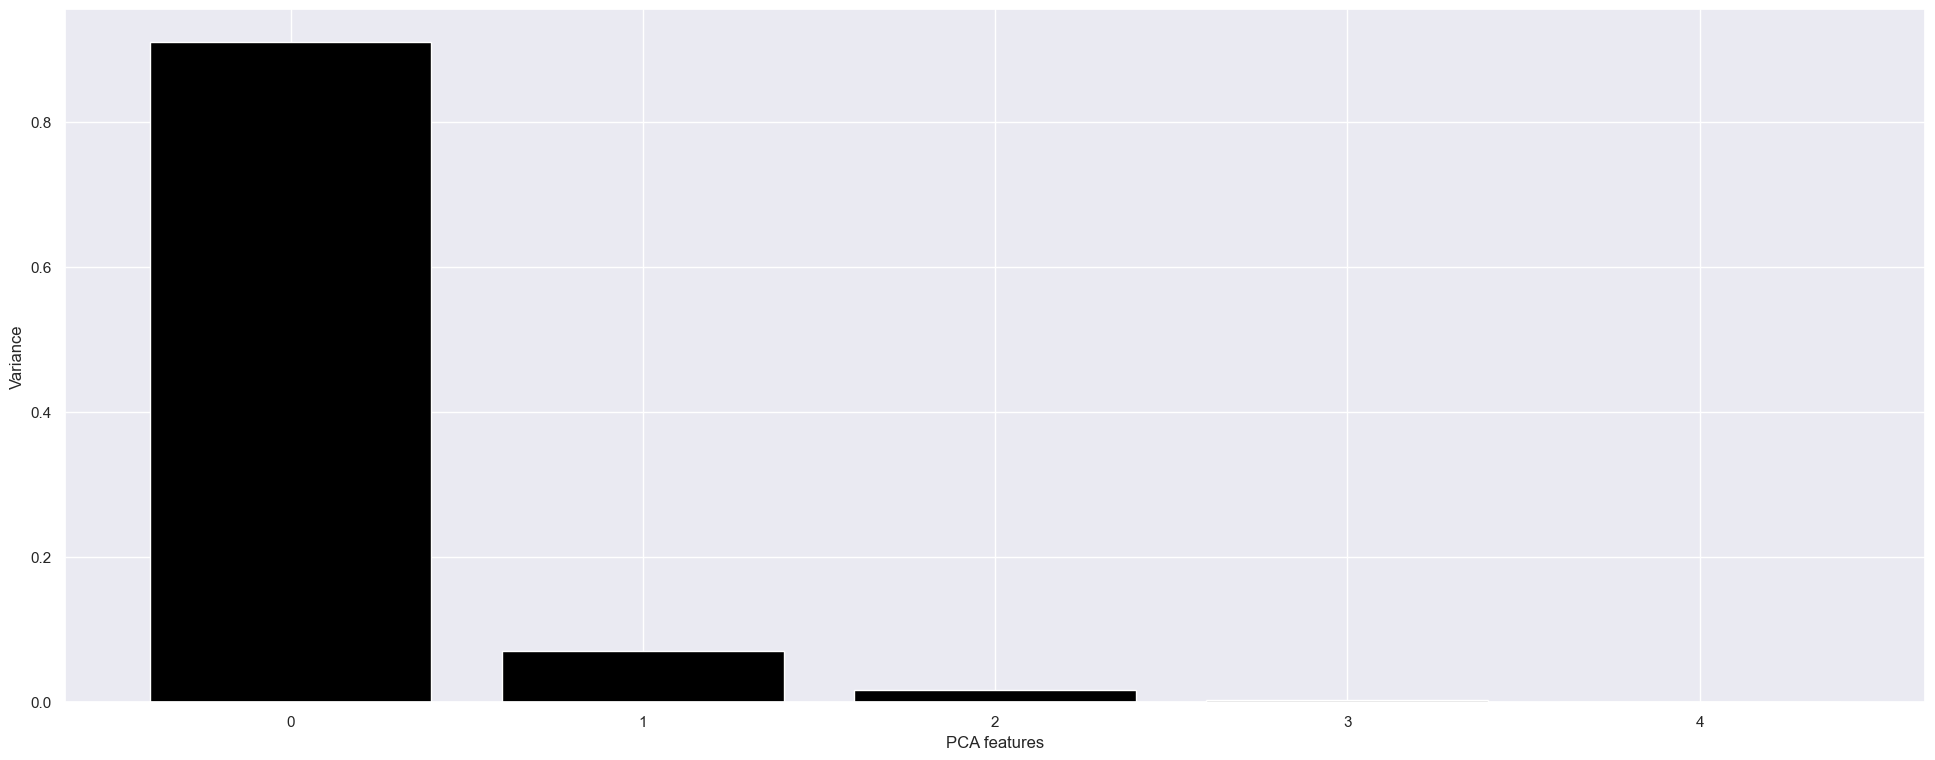

In [59]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )
plt.xlabel('PCA features')
plt.ylabel('Variance')
plt.xticks(features)

# pca component
df_pca = pd.DataFrame( principal_components )

<Axes: xlabel='0', ylabel='1'>

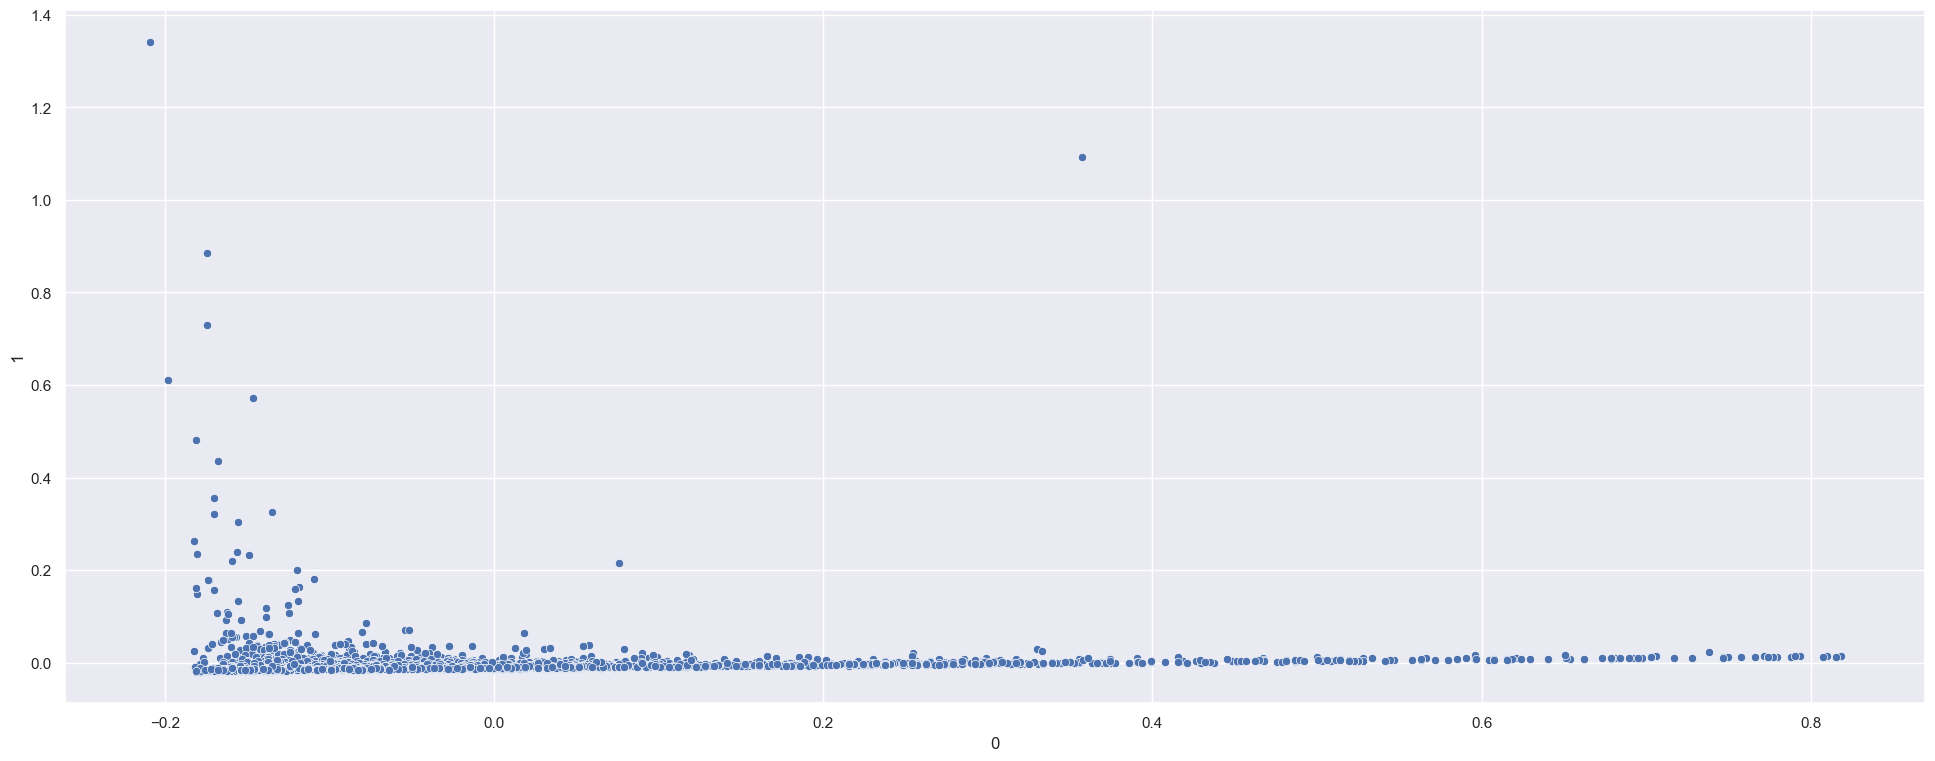

In [60]:
sns.scatterplot( x=0, y=1, data=df_pca ) 

### 4.3.2. UMAP

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

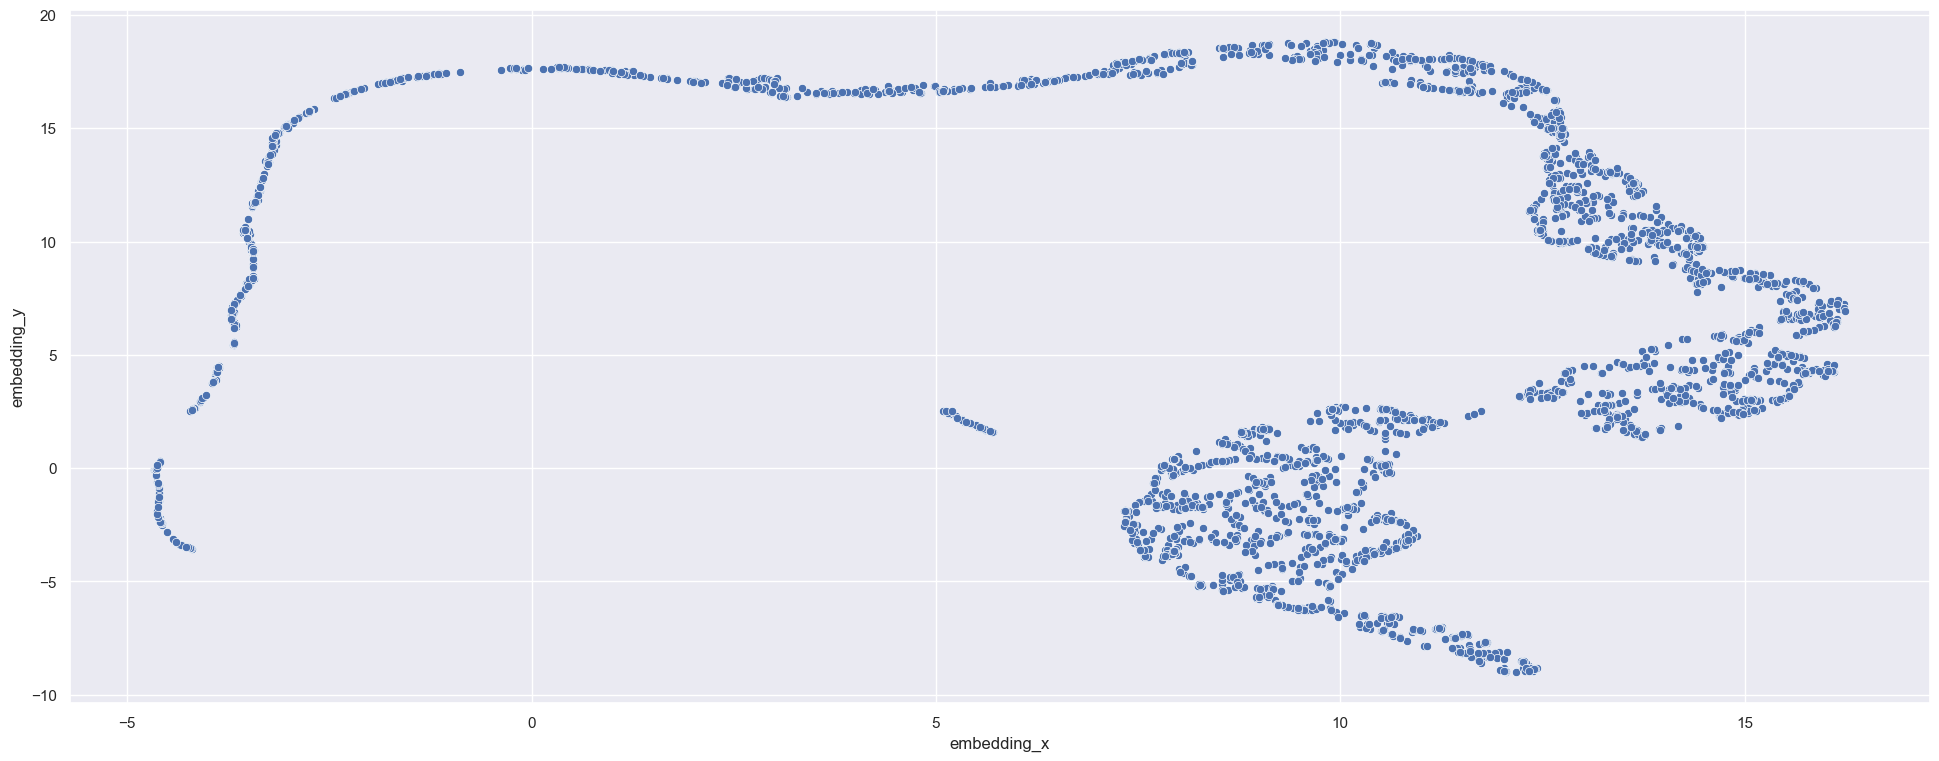

In [63]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.2. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

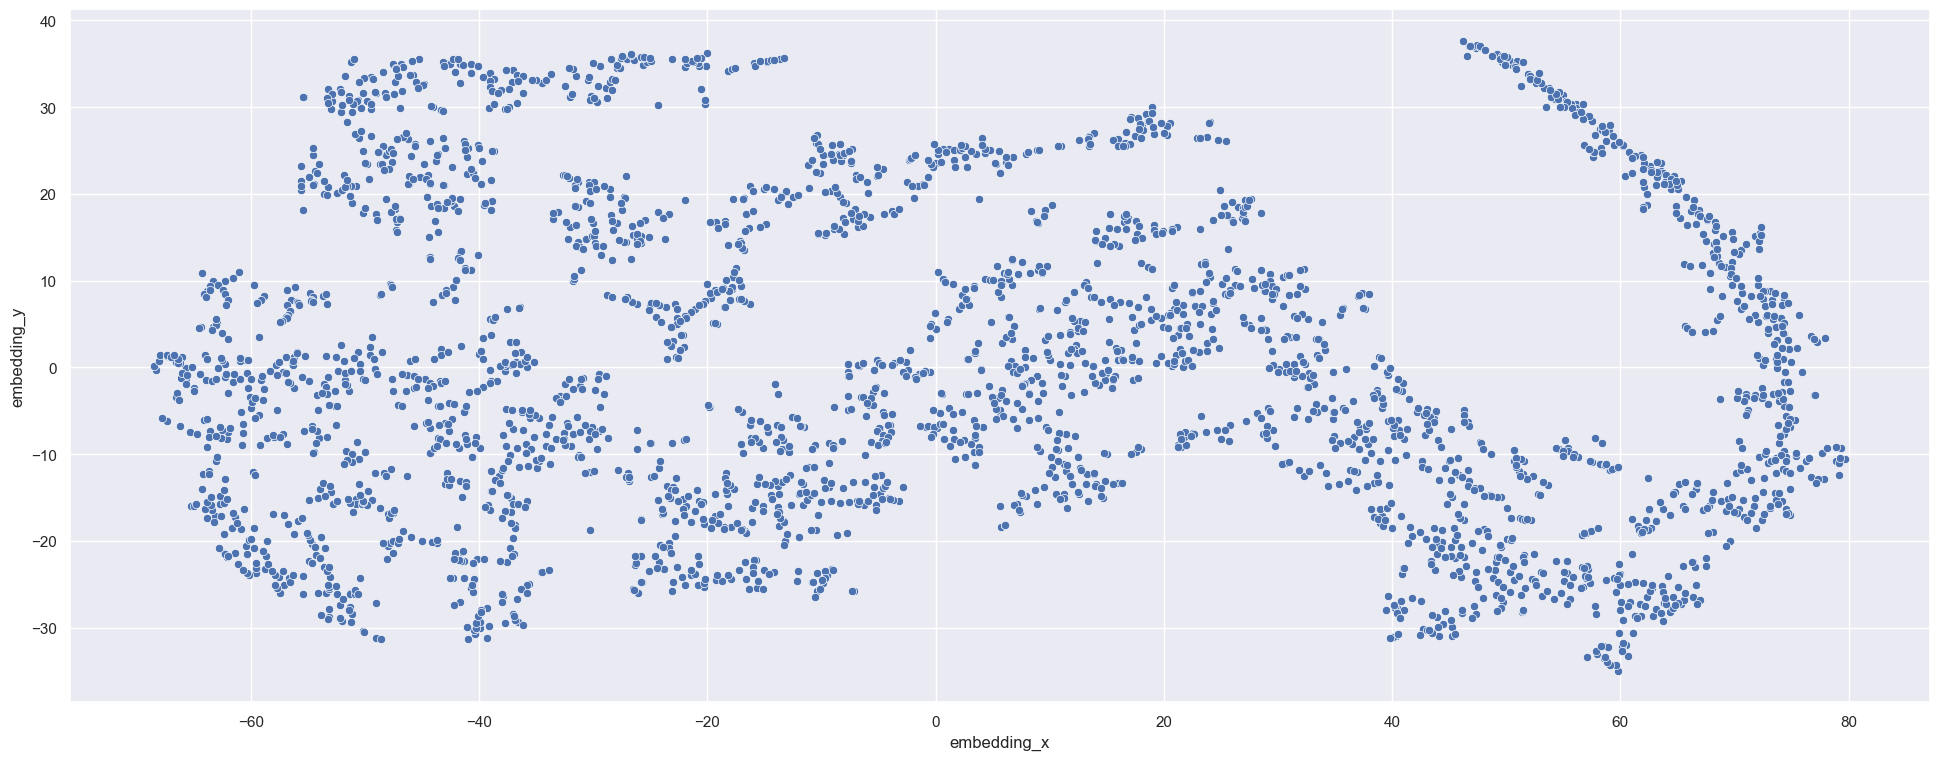

In [67]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.3. Tree-Based Embedding

In [68]:
# training dataset
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [69]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

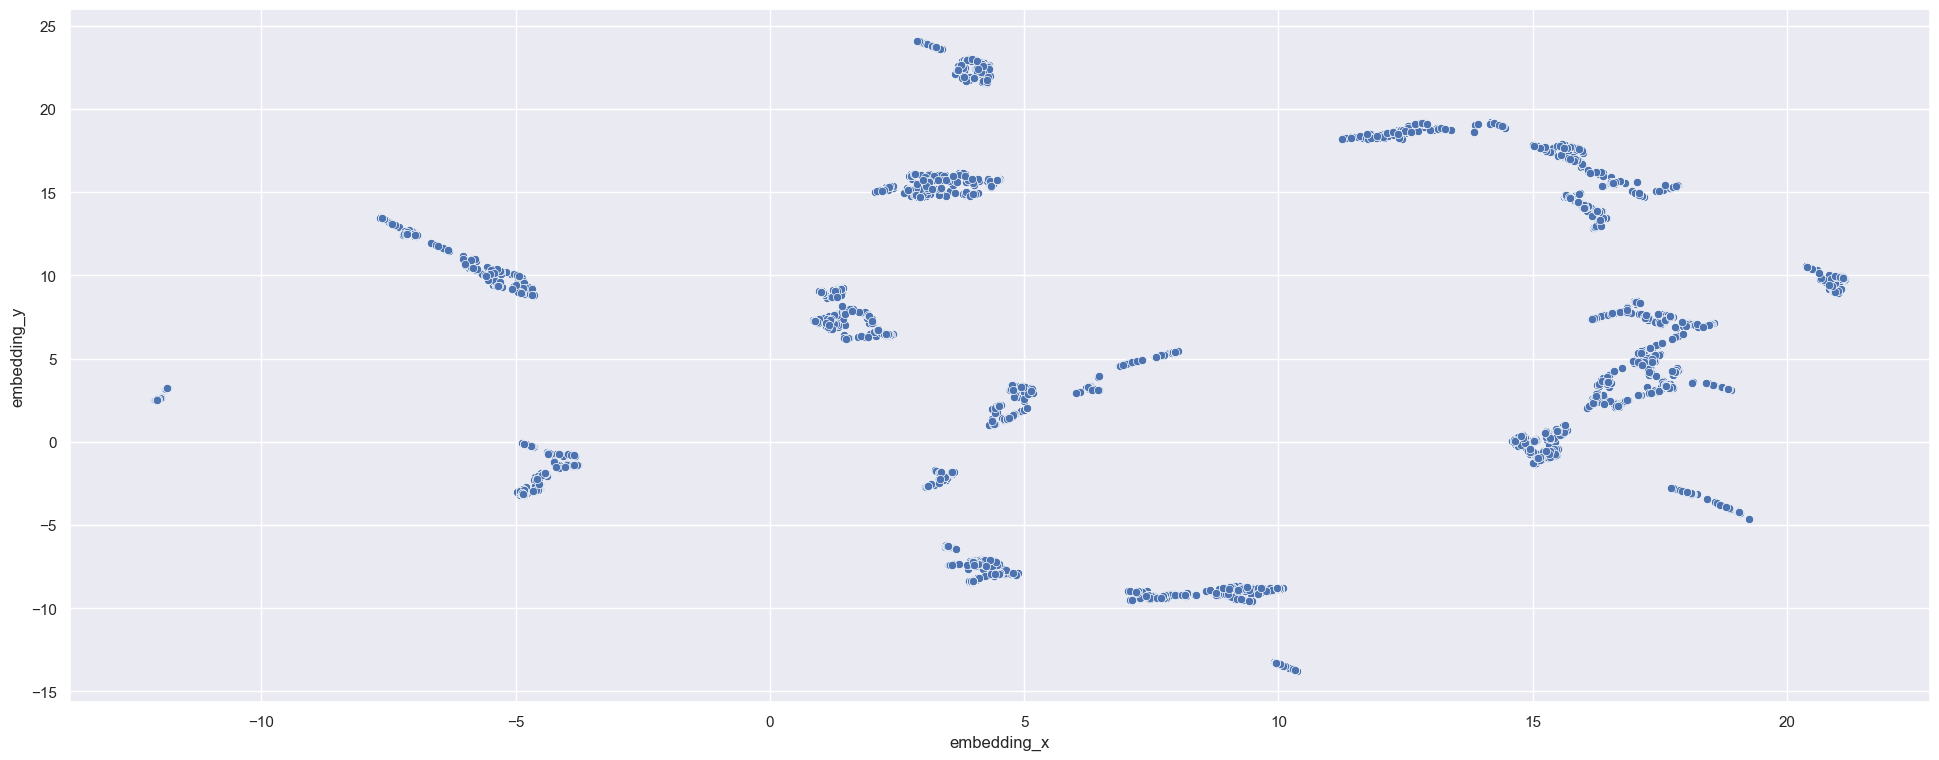

In [70]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 5.0 Data Preparation

In [71]:
df5 = df4.copy()

In [72]:
## Standard Scalaer
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['qtde_invoices'] = ss.fit_transform( df5[['qtde_invoices']] )
df5['qtde_items'] = ss.fit_transform( df5[['qtde_items']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['avg_recency_days'] = ss.fit_transform( df5[['avg_recency_days']] )
df5['frequency'] = ss.fit_transform( df5[['frequency']] )
df5['qtde_returns'] = ss.fit_transform( df5[['qtde_returns']] )
df5['avg_basket_size'] = ss.fit_transform( df5[['avg_basket_size']] )
df5['avg_unique_basket_size'] = ss.fit_transform( df5[['avg_unique_basket_size']] )

In [73]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.249733,3.958037,3.193307,0.021090,297.0,-0.032549,0.501281,41.378877,-0.014652,-0.251248,-1.091168
1,13047,0.045683,-0.106602,0.370056,-0.037178,171.0,-0.031824,0.631132,-0.209503,-0.017958,-0.120504,-0.376377
2,12583,0.373960,-0.801192,1.047636,0.580837,232.0,-0.022180,0.695074,-0.180046,-0.008039,0.107890,-0.639461
3,13748,-0.170252,0.395046,-0.081664,-0.198732,28.0,-0.017392,-0.398496,-0.234940,-0.041103,-0.204712,-0.820600
4,15100,-0.177082,3.456388,-0.307524,-0.259718,3.0,0.231589,0.924675,-0.099554,-0.026555,-0.281957,-1.109561


# 6.0 Feature Selection 

# 7.0 Hyperparameter Fine-Tunning 

## 7.1 K-Means

## 7.2 GMM

## 7.3 Hierarchical Clustering